In [1]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../flaming-choripan') # or just install the module
sys.path.append('../../astro-lightcurves-handler') # or just install the module

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
==============================linear-fstw
Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 5-fold cross-validation in test-set)


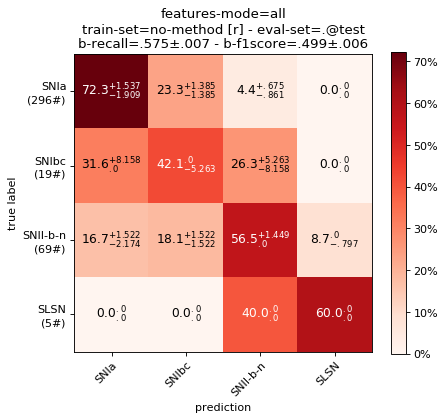

KeyError: 'test'

In [7]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import search_for_filedirs, gather_files_by_kfold
from flamingchoripan.cuteplots.cm_plots import plot_custom_confusion_matrix
import matplotlib.pyplot as plt
from flamingchoripan.datascience.xerror import XError
from IPython.display import display

def get_kf_text(set_name, kf):
    if kf=='.':
        return f'($\\mu\\pm\\sigma$ from 5-fold cross-validation in {set_name}-set)'
    else:
        return f'($\\mu\\pm\\sigma$ from {kf} k-fold in {set_name}-set)'

def get_mode_text(mode, features):
    if mode=='sne':
        return f'Using {len(features)} SNe selected astrophysical features'
    else:
        return f'Using {len(features)} astrophysical features'
    
mode = 'all' # all sne
methods = [
    'linear-fstw',
    'bspline-fstw',
    #'spm-mle-fstw',
    'spm-mcmc-fstw',
    #'spm-mle-estw',
    'spm-mcmc-estw',
]
#methods = ['spm-mcmc-estw']
eval_lcset_name = 'test'
kf = '.'

for method in methods:
    print('='*30+method)
    for train_config in ['r', 's', 'r+s']:
        rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
        files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
        class_names = files[0]()['lcset_info']['class_names']
        features = files[0]()['features']
        cms = np.concatenate([f()['cm'][None] for f in files], axis=0)
        bprecision_xe = XError([f()['metrics_dict']['b-precision'] for f in files])
        brecall_xe = XError([f()['metrics_dict']['b-recall'] for f in files])
        bf1score_xe = XError([f()['metrics_dict']['b-f1score'] for f in files])

        ### plot cm
        _title = 'no-method [r]' if train_config=='r' else f'{method} [{train_config}]'
        title = ''
        title += f'features-mode={mode}'+'\n'
        title += f'train-set={_title} - eval-set={kf}@{eval_lcset_name}'+'\n'
        #title += f'b-p/r={bprecision_xe} / {brecall_xe}'+'\n'
        #title += f'b-f1score={bf1score_xe}'+'\n'
        title += f'b-recall={brecall_xe} - b-f1score={bf1score_xe}'+'\n'
        cm_kwargs = {
            'title':title[:-1],
            'figsize':(6,5),
            'new_order_classes':['SNIa', 'SNIbc', 'SNII-b-n', 'SLSN'],
        }
        fig, ax, cm_norm = plot_custom_confusion_matrix(cms, class_names, **cm_kwargs)
        #accu = XError(np.diagonal(cm_norm*100, axis1=1, axis2=2).flatten().tolist())
        #title += f'b-accu={accu}'+'\n'
        #ax.set_title(title[:-1])
        caption = ''
        caption += f'Confusion matrix.'
        caption += f' {get_mode_text(mode, features)} {get_kf_text(eval_lcset_name, kf)}'
        print(caption)
        plt.show()

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.xerror import XError
from flamingchoripan.dataframes import DFBuilder
from flamingchoripan.latex.latex_tables import LatexTable

dmetrics = {
    f'b-precision':{'k':1, 'mn':None},
    f'b-recall':{'k':1, 'mn':None},
    f'b-f1score':{'k':1, 'mn':None},
    f'b-rocauc':{'k':1, 'mn':'b-AUCROC'},
    #f'b-prauc':{'k':1, 'mn':'b-AUCPR'},
    }
info_df = DFBuilder()
for train_config in ['r', 's', 'r+s']:
    aux_r = []
    for method in methods:
        d = {}
        for metric in dmetrics.keys():
            mn = metric if dmetrics[metric]['mn'] is None else dmetrics[metric]['mn']
            rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
            files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
            class_names = files[0]()['lcset_info']['class_names']
            features = files[0]()['features']
            metric_xe = XError([f()['metrics_dict'][metric]*dmetrics[metric]['k'] for f in files])
            d[mn] = metric_xe
            #print(len(metric_xe))
        
        if not train_config=='r': # mean across methods in real case
            info_df.append(f'synthetic-method={method} [{train_config}]', d)
        else:
            aux_r.append(d)

    if train_config=='r': # mean across methods in real case
        for r in aux_r:
            print(r)
        new_d = {k:sum([r[k] for r in aux_r]) for k in d.keys()}
        info_df.append(f'synthetic-method=no-method [{train_config}]', new_d)
            
display(info_df())
caption = ''
caption += f'Synthetic generation methods scores using only real samples [r], only synthetic samples [s], and the same proportion of real and synthetic samples [r+s].'
caption += f' {get_mode_text(mode, features)} {get_kf_text(eval_lcset_name, kf)}'

latex_kwargs = {
    'caption':caption,
    'label':'?',
    #'bold_axis':'columns',
}
latex_table = LatexTable(info_df(), **latex_kwargs)
print(latex_table)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'b-precision': .479±.022, 'b-recall': .576±.051, 'b-f1score': .492±.028, 'b-AUCROC': .798±.033}
{'b-precision': .476±.021, 'b-recall': .567±.045, 'b-f1score': .487±.022, 'b-AUCROC': .799±.030}
{'b-precision': .480±.021, 'b-recall': .577±.053, 'b-f1score': .494±.026, 'b-AUCROC': .801±.032}
{'b-precision': .482±.023, 'b-recall': .575±.051, 'b-f1score': .494±.027, 'b-AUCROC': .799±.032}


,b-precision,b-recall,b-f1score,b-AUCROC
synthetic-method=no-method [r],.479±.022,.574±.050,.491±.026,.799±.032
synthetic-method=linear-fstw [s],.461±.018,.578±.041,.463±.029,.794±.022
synthetic-method=bspline-fstw [s],.461±.023,.568±.053,.452±.043,.775±.032
synthetic-method=spm-mcmc-fstw [s],.460±.018,.577±.040,.465±.025,.798±.024
synthetic-method=spm-mcmc-estw [s],.467±.023,.582±.033,.476±.032,.795±.025
synthetic-method=linear-fstw [r+s],.475±.017,.587±.039,.484±.022,.799±.027
synthetic-method=bspline-fstw [r+s],.476±.019,.579±.042,.477±.025,.790±.027
synthetic-method=spm-mcmc-fstw [r+s],.483±.019,.597±.034,.495±.024,.805±.024
synthetic-method=spm-mcmc-estw [r+s],.479±.019,.589±.035,.489±.022,.805±.025


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{Synthetic generation methods scores using only real samples [r], only synthetic samples [s], and the same proportion of real and synthetic samples [r+s]. Using 26 SNe selected astrophysical features ($\mu\pm\sigma$ from 5-fold cross-validation in test-set)}
\label{?}\vspace{.1cm}
\begin{tabular}{l|cccc}
\hline
synthetic-method & b-precision & b-recall & b-f1score & b-AUCROC \srule\\\hline\hline
no-method [r] & .479$\pm$.022 & .574$\pm$.050 & .491$\pm$.026 & .799$\pm$.032  \srule\\
linear-fstw [s] & .461$\pm$.018 & .578$\pm$.041 & .463$\pm$.029 & .794$\pm$.022  \srule\\
bspline-fstw [s] & .461$\pm$.023 & .568$\pm$.053 & .452$\pm$.043 & .775$\pm$.032  \srule\\
spm-mcmc-fstw [s] & .460$\pm$.018 & .577$\pm$.040 & .465$\pm$.025 & .798$\pm$.024  \srule\\
spm-mcmc-estw [s] & .467$\pm$.023 & .582$\pm$.033 & .476

In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.xerror import XError
from flamingchoripan.dataframes import DFBuilder
from flamingchoripan.latex.latex_tables import LatexTable

info_df = DFBuilder()
train_config = 'r+s' # r s r+s
rank_n = 10
for k in range(0, rank_n):
    d = {}
    for method in methods:
        rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
        files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
        class_names = files[0]()['lcset_info']['class_names']
        features = files[0]()['features']
        rank = files[0]()['rank'] # just show one
        feature_name, feature_p,_ = rank[k]
        feature_name = feature_name.replace('_', '-')
        d[f'{method} [{train_config}]'] = f'{feature_name} ({feature_p*100:.2f}%)'

    info_df.append(f'k={k+1}', d)

caption = ''
caption += f'Random Forest astrophysical features ranking (top {rank_n}) using the same proportion of real and synthetic samples [r+s].'
caption += f' {get_mode_text(mode, features)}.'

latex_kwargs = {
    'caption':caption,
    'label':'?',
    #'custom_tabular_align':'l|'+'c'*sum([m.split('-')[-1]=='fstw' for m in methods])+'|'+'c'*sum([m.split('-')[-1]=='estw' for m in methods]),
}
latex_table = LatexTable(info_df(), **latex_kwargs)
print(latex_table)
info_df()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{Random Forest astrophysical features ranking (top 10) using the same proportion of real and synthetic samples [r+s]. Using 26 SNe selected astrophysical features.}
\label{?}\vspace{.1cm}
\begin{tabular}{l|cccc}
\hline
k & linear-fstw [r+s] & bspline-fstw [r+s] & spm-mcmc-fstw [r+s] & spm-mcmc-estw [r+s] \srule\\\hline\hline
1 & SPM-t0-r (19.44\%) & SPM-t0-g (21.51\%) & SPM-t0-g (16.32\%) & SPM-t0-g (33.55\%)  \srule\\
2 & SPM-t0-g (11.98\%) & LinearTrend-g (17.74\%) & LinearTrend-g (15.97\%) & SPM-t0-r (13.72\%)  \srule\\
3 & LinearTrend-g (10.38\%) & LinearTrend-r (11.51\%) & SPM-t0-r (11.26\%) & SPM-tau-rise-r (10.16\%)  \srule\\
4 & LinearTrend-r (8.99\%) & SPM-gamma-r (11.01\%) & SPM-gamma-r (10.74\%) & SPM-gamma-

,linear-fstw [r+s],bspline-fstw [r+s],spm-mcmc-fstw [r+s],spm-mcmc-estw [r+s]
k=1,SPM-t0-r (19.44%),SPM-t0-g (21.51%),SPM-t0-g (16.32%),SPM-t0-g (33.55%)
k=2,SPM-t0-g (11.98%),LinearTrend-g (17.74%),LinearTrend-g (15.97%),SPM-t0-r (13.72%)
k=3,LinearTrend-g (10.38%),LinearTrend-r (11.51%),SPM-t0-r (11.26%),SPM-tau-rise-r (10.16%)
k=4,LinearTrend-r (8.99%),SPM-gamma-r (11.01%),SPM-gamma-r (10.74%),SPM-gamma-r (8.50%)
k=5,SPM-gamma-r (6.67%),SPM-beta-r (7.13%),LinearTrend-r (10.73%),SPM-gamma-g (6.38%)
k=6,SPM-tau-rise-r (5.77%),SPM-gamma-g (6.32%),SPM-tau-rise-r (4.92%),SPM-tau-fall-r (3.76%)
k=7,SPM-tau-rise-g (5.58%),SPM-t0-r (6.18%),SPM-tau-fall-g (4.43%),SPM-beta-r (3.05%)
k=8,SPM-tau-fall-r (4.96%),IAR-phi-g (2.70%),SPM-gamma-g (4.11%),SPM-tau-fall-g (2.91%)
k=9,SPM-tau-fall-g (3.80%),SPM-tau-fall-g (2.54%),SPM-tau-fall-r (3.94%),LinearTrend-g (2.62%)
k=10,SPM-gamma-g (3.29%),SPM-tau-rise-r (2.19%),SPM-beta-r (3.41%),IAR-phi-g (2.09%)
